In [3]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import numpy as np
import scipy.linalg as la

from matplotlib import pyplot as plt, rcParams
from matplotlib_inline.backend_inline import set_matplotlib_formats

rcParams["figure.figsize"] = (8, 5)
rcParams["figure.dpi"] = 100
set_matplotlib_formats("retina")
plt.style.use("seaborn")

In [6]:
output = np.load("output/output.npz")

X = output["activations"]
y = output["targets"].squeeze()

In [99]:
Xorig = X[:,25]
pca = PCA(n_components=1600)
Xhat = pca.fit_transform(Xorig)

In [165]:
def correlate(X, y):
    return [np.corrcoef(x, y)[0,1] for x in X.T]

In [144]:
pca.explained_variance_ratio_[:5].sum()

0.8282627

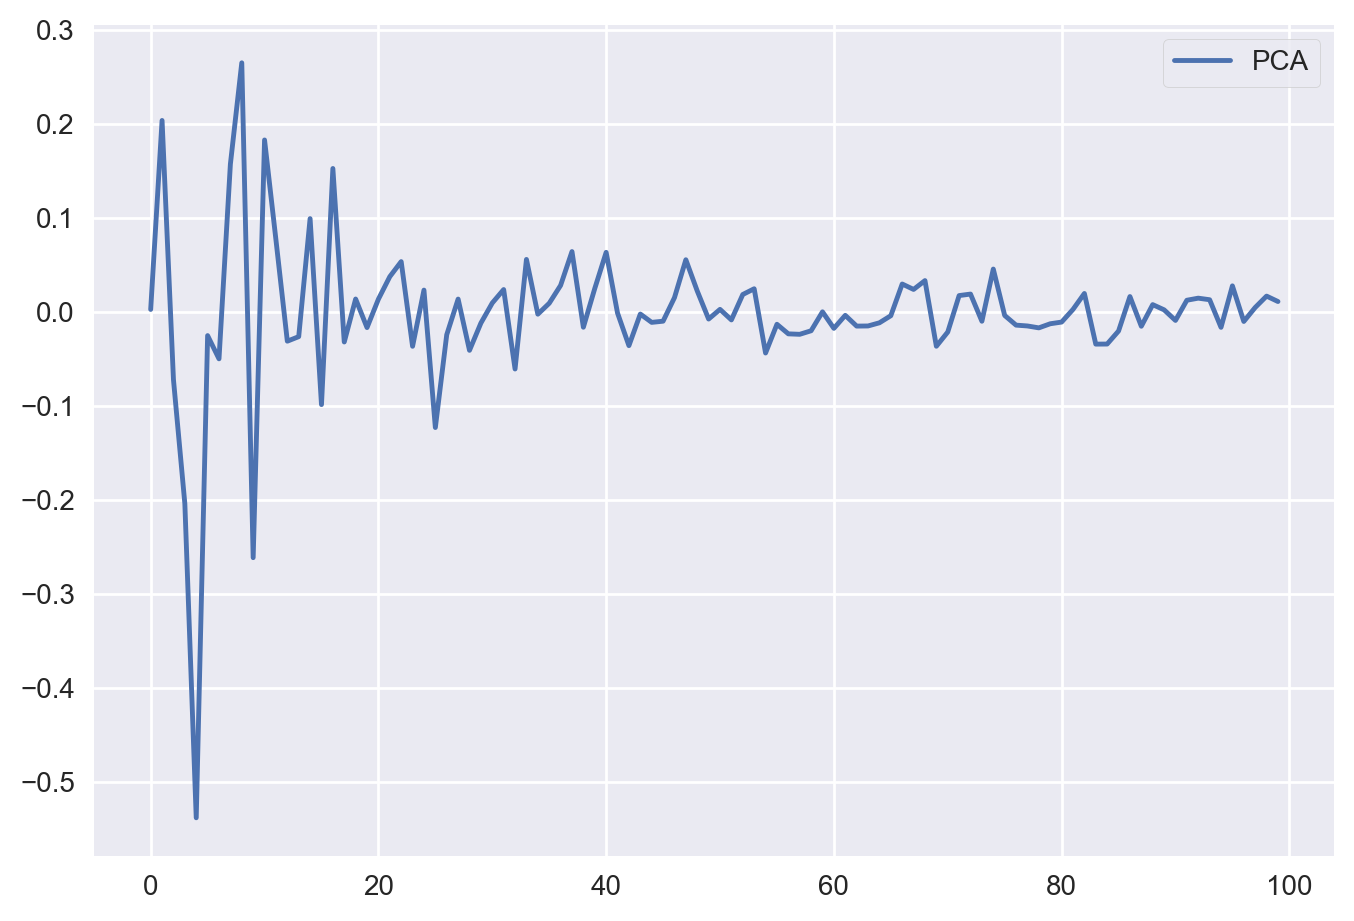

In [145]:
# plt.plot(correlate(Xorig, y), label="Original")
plt.plot(correlate(Xhat, y)[:100], label="PCA")
# plt.plot(pca.explained_variance_ratio_[5:105], label="Ratios")
plt.legend(frameon=True)
plt.show()

In [120]:
all_corrs = np.array(
    [
        correlate(PCA(n_components=X.shape[-1]).fit_transform(Xi), y)
        for Xi in np.transpose(X, axes=(1, 0, 2))
    ]
)


In [126]:
old_corrs = np.array(
    [
        correlate(Xi, y)
        for Xi in np.transpose(X, axes=(1, 0, 2))
    ]
)

In [121]:
all_corrs.shape

(49, 1600)

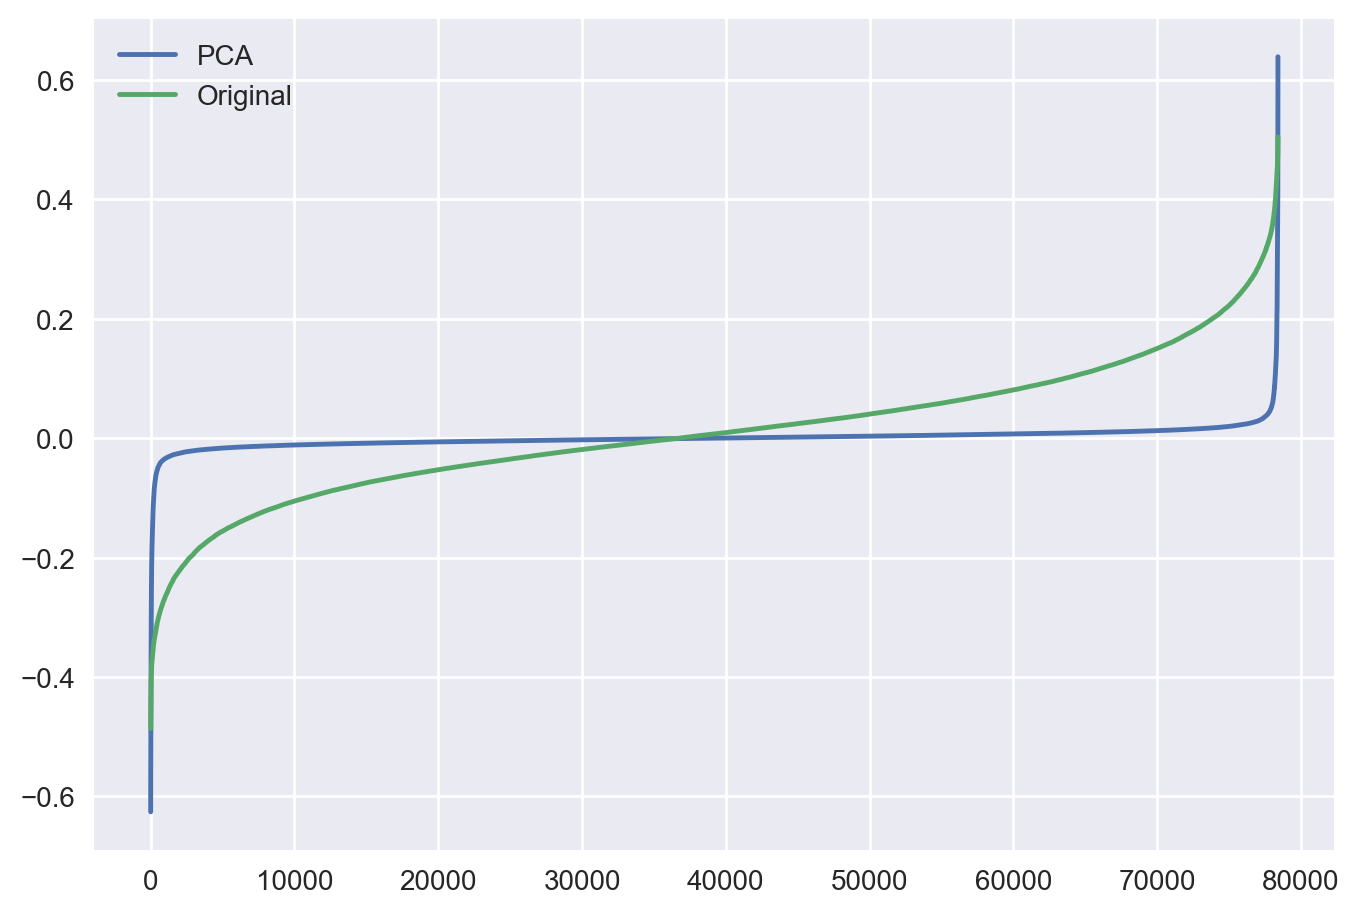

In [127]:
plt.plot(sorted(all_corrs.ravel()), label="PCA")
plt.plot(sorted(old_corrs.ravel()), label="Original")
plt.legend()
plt.show()

In [166]:
np.abs(all_corrs).argmax(axis=1)

array([ 6,  7, 20, 17, 16, 17, 17, 19, 16,  7,  7, 15, 15, 14, 14, 11, 11,
        9,  3,  7,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  3])

In [189]:
top_neuron = np.abs(all_corrs.ravel()).argmax()

In [192]:
dist = Xhat.reshape(Xhat.shape[0], -1)[:, top_neuron]

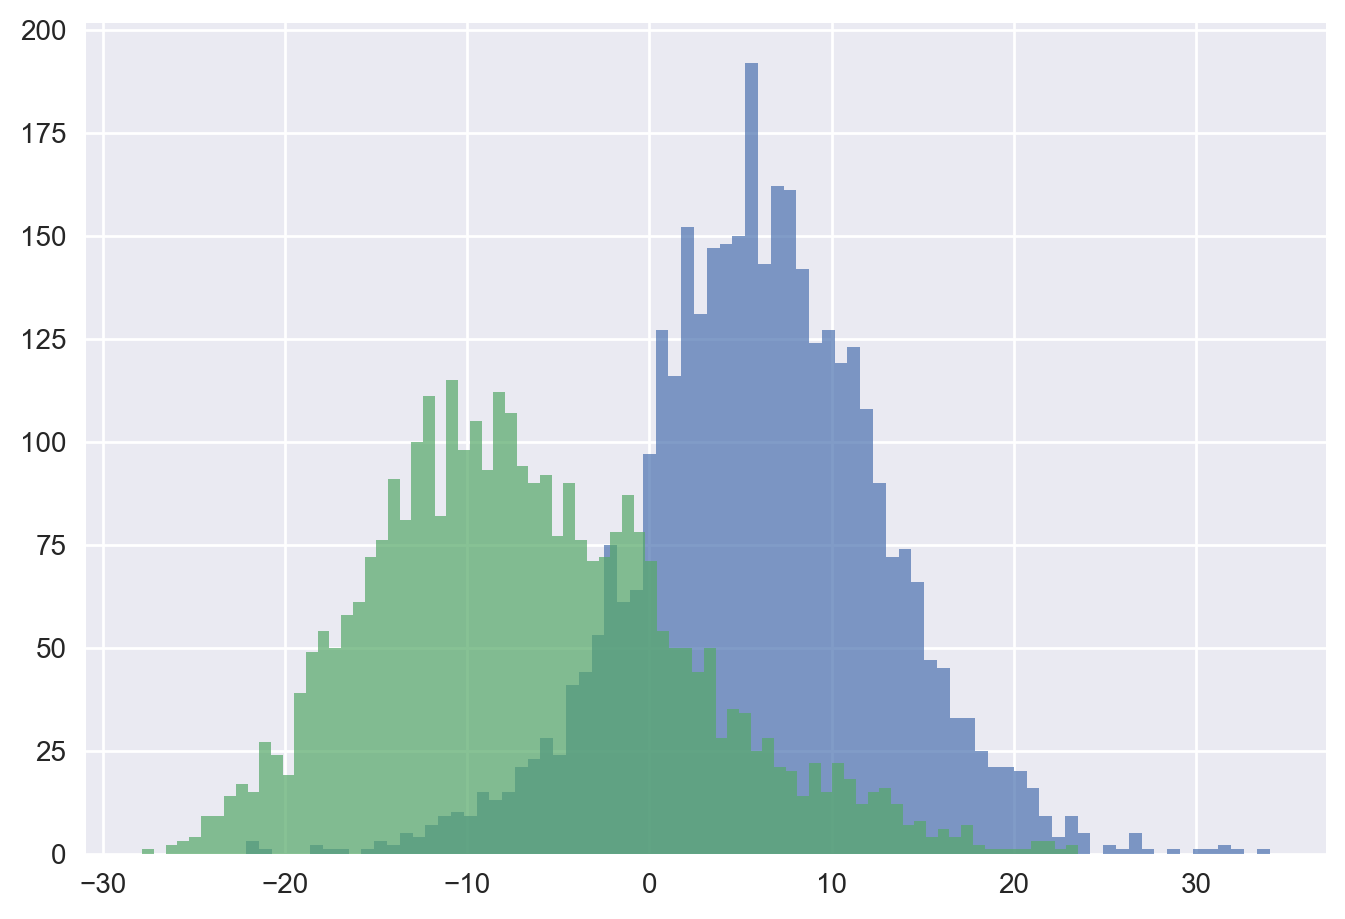

In [207]:
plt.hist(dist[y==1], alpha=0.7, bins=80)
plt.hist(dist[y==0], alpha=0.7, bins=80)
plt.show()

In [181]:
Xhat = np.array(
    [
        PCA(n_components=Xi.shape[-1]).fit_transform(Xi)
        for Xi in np.transpose(X, axes=(1, 0, 2))
    ]
)


In [183]:
Xhat = np.transpose(Xhat, axes=(1, 0, 2))

In [206]:
sorted(np.abs(all_corrs).ravel())[::-1][100]

0.2529676221969654

In [216]:
dim = 2
shape = (1,2,3)
shape = shape[dim:dim+1] + shape[:dim] + shape[dim+1:]
shape

(3, 1, 2)

# LDA

In [21]:
import torch
torch.tensor(np.ones((2, 1)), dtype=torch.float)

tensor([[1.],
        [1.]])

In [4]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [7]:
lda = LinearDiscriminantAnalysis()
Xorig = X[:,25]
Xlda = lda.fit_transform(Xorig, y)
# Xlda = Xorig @ lda.scalings_

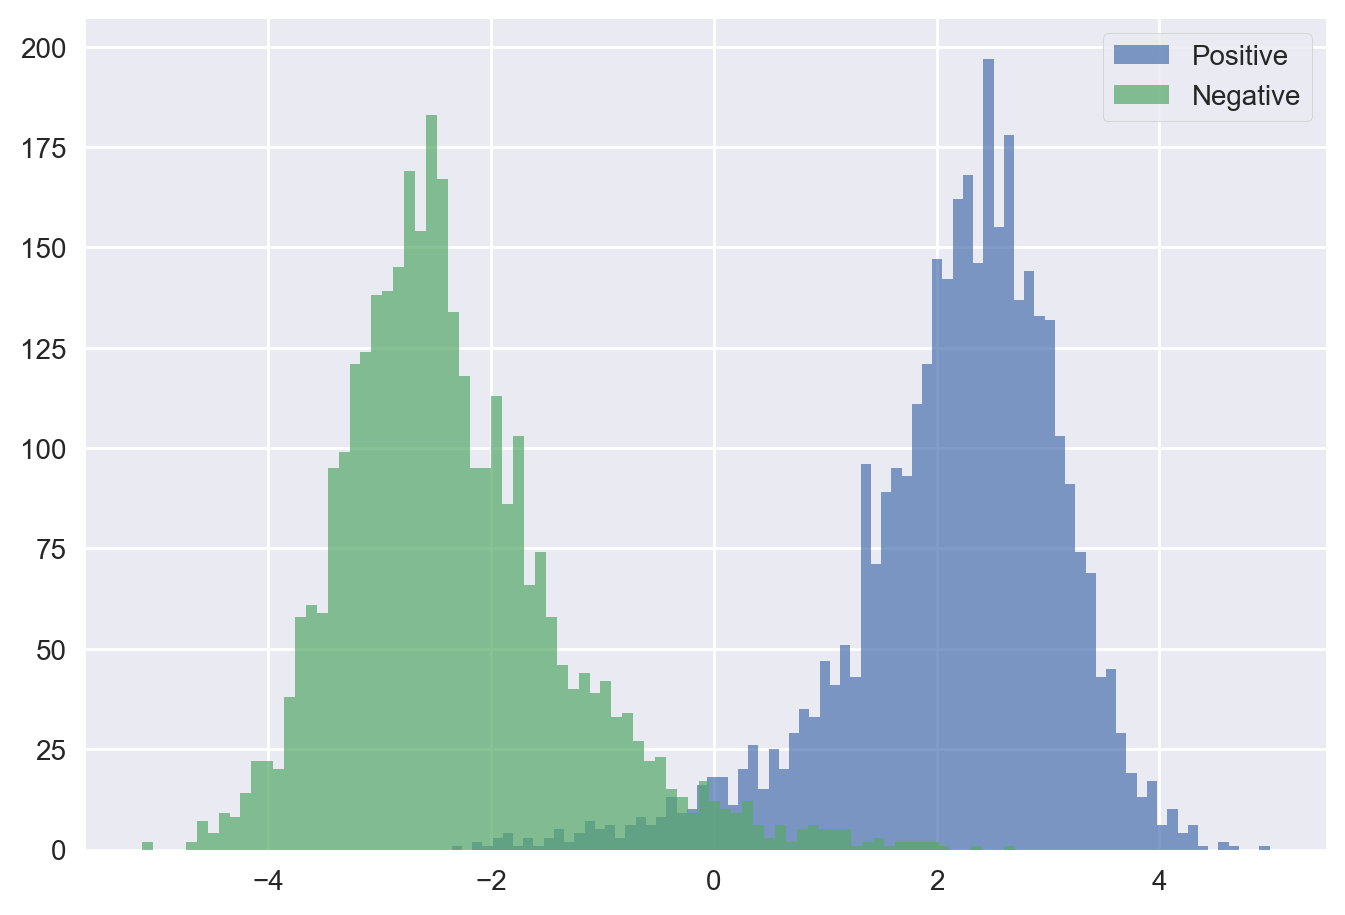

In [8]:
plt.hist(Xlda[y==1], alpha=0.7, bins=80, label="Positive")
plt.hist(Xlda[y==0], alpha=0.7, bins=80, label="Negative")
plt.legend(frameon=True)
plt.show()

In [9]:
lda = LinearDiscriminantAnalysis()
model = LogisticRegression()

accs = []
for Xi in np.transpose(X, axes=(1,0,2)):
    lda.fit(Xi, y)
    projection = lda.scalings_ / la.norm(lda.scalings_)
    dist = Xi @ projection
    model.fit(dist, y)
    acc = model.score(dist, y)
    accs.append(acc)

In [10]:
np.argmax(accs)

25

In [113]:
i = np.argmax(accs)
percentile = 0.8

lda = LinearDiscriminantAnalysis()
lda.fit(X[:, i], y)

projection = lda.scalings_
projection = projection / la.norm(projection)

dist = X[:, i] @ projection

if dist[y == 1].mean() > dist[y == 0].mean():
    pos_val = np.quantile(dist[y == 1], percentile)
    neg_val = np.quantile(dist[y == 0], 1 - percentile)
else:
    pos_val = np.quantile(dist[y == 1], 1 - percentile)
    neg_val = np.quantile(dist[y == 0], percentile)

neurons_per_layer = {
    i: {
        "projection": projection,
        "positive": pos_val,
        "negative": neg_val,
    },
}


# Test LDA Extended

In [76]:
A = np.arange(12).reshape(4,3)
y = np.array([1,1,0,0])
A

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11]])

In [77]:
lda = LinearDiscriminantAnalysis()
B = lda.fit_transform(A, y)

In [78]:
(A - A.mean(axis=0).reshape(1,-1)) @ lda.scalings_

array([[-2.12132034],
       [-0.70710678],
       [ 0.70710678],
       [ 2.12132034]])

In [83]:
projection = lda.scalings_ / la.norm(lda.scalings_)

In [88]:
B = (A - lda.xbar_) @ projection
B @ projection.T + lda.xbar_

array([[-1.77635684e-15,  1.00000000e+00,  2.00000000e+00],
       [ 3.00000000e+00,  4.00000000e+00,  5.00000000e+00],
       [ 6.00000000e+00,  7.00000000e+00,  8.00000000e+00],
       [ 9.00000000e+00,  1.00000000e+01,  1.10000000e+01]])

# LDA in GPT2

In [44]:
from transformers import GPT2Tokenizer, GPT2Model
import torch

In [33]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2-xl")
model = GPT2Model.from_pretrained("gpt2-xl")
model.eval()

GPT2Model(
  (wte): Embedding(50257, 1600)
  (wpe): Embedding(1024, 1600)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0): GPT2Block(
      (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): GPT2Block(
      (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
      (mlp): G

In [34]:
sentence = "I like dogs."
input = tokenizer.encode(sentence.strip(), return_tensors="pt")

In [36]:
output = model(input, output_hidden_states=True)

In [41]:
output.hidden_states[10].shape

torch.Size([1, 4, 1600])

In [49]:
torch.allclose((output.hidden_states[10] @ delta)[0, -1], output.hidden_states[10][0,-1] @ delta)

True

In [45]:
delta = torch.ones(1600)
delta.shape

torch.Size([1600])

In [56]:
weights = (output.hidden_states[10] @ delta)

In [60]:
weights.squeeze().unsqueeze(-1).shape

torch.Size([4, 1])

In [61]:
delta.unsqueeze(0).shape

torch.Size([1, 1600])

In [67]:
(weights.squeeze().unsqueeze(-1) * delta.unsqueeze(0)).shape

torch.Size([4, 1600])

In [ ]:
lda.fit(X[:, 25])

In [ ]:
neurons_per_layer = {
    25: 
}